# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

# Enviroment Set-Up

In [2]:
#set up JPL GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"

Create a HOME constant.

In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/pundaky/JPLprojects/segment-anything/notebooks


# Load Model

In [4]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_b"

In [5]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-hq68_r4y
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-hq68_r4y
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [11]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

chkpt_path = '/home/pundaky/JPLprojects/segment-anything/weights/sam_vit_b_01ec64.pth' #using grace's weights, can try using CUDA to see if get better results
sam = sam_model_registry[MODEL_TYPE](checkpoint=chkpt_path).to(device=DEVICE)
#predictor = SamPredictor(sam)

## Define 'show_anns' Function

 The show_anns function is used to visualize annotations (masks) associated with objects in an image using matplotlib. This function takes a list of annotation dictionaries (masks), sorts them based on area in descending order, and then creates an RGBA image with colored annotations overlaying a transparent background in descending order of mask area. It uses matplotlib to display this image on a plot. 

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [14]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [15]:
image = cv2.imread('/home/pundaky/JPLprojects/segment-anything/notebooks/images/MSRsampleTube.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

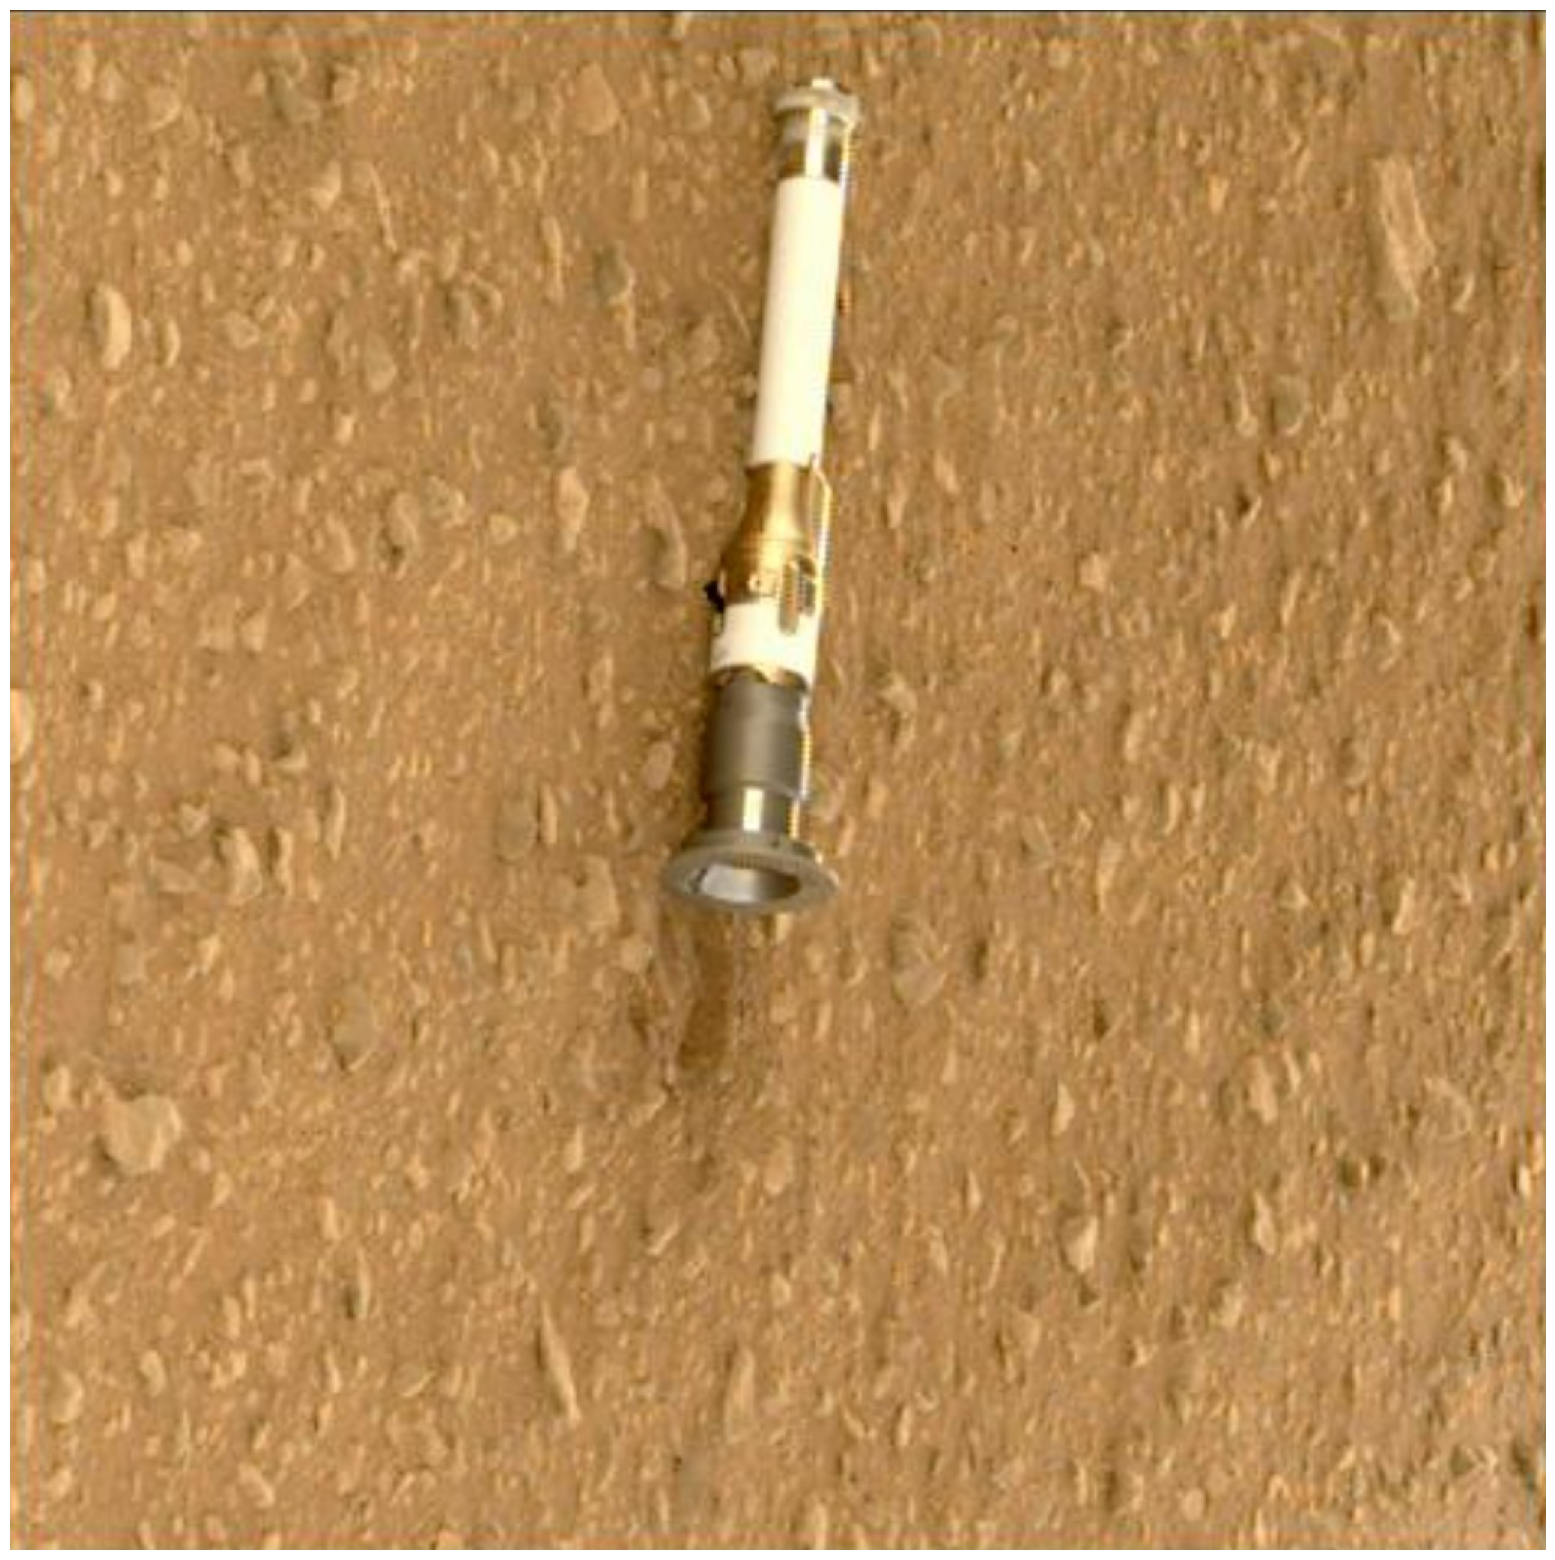

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [17]:
mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [18]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [19]:
print(len(masks))
print(masks[0].keys())

50
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

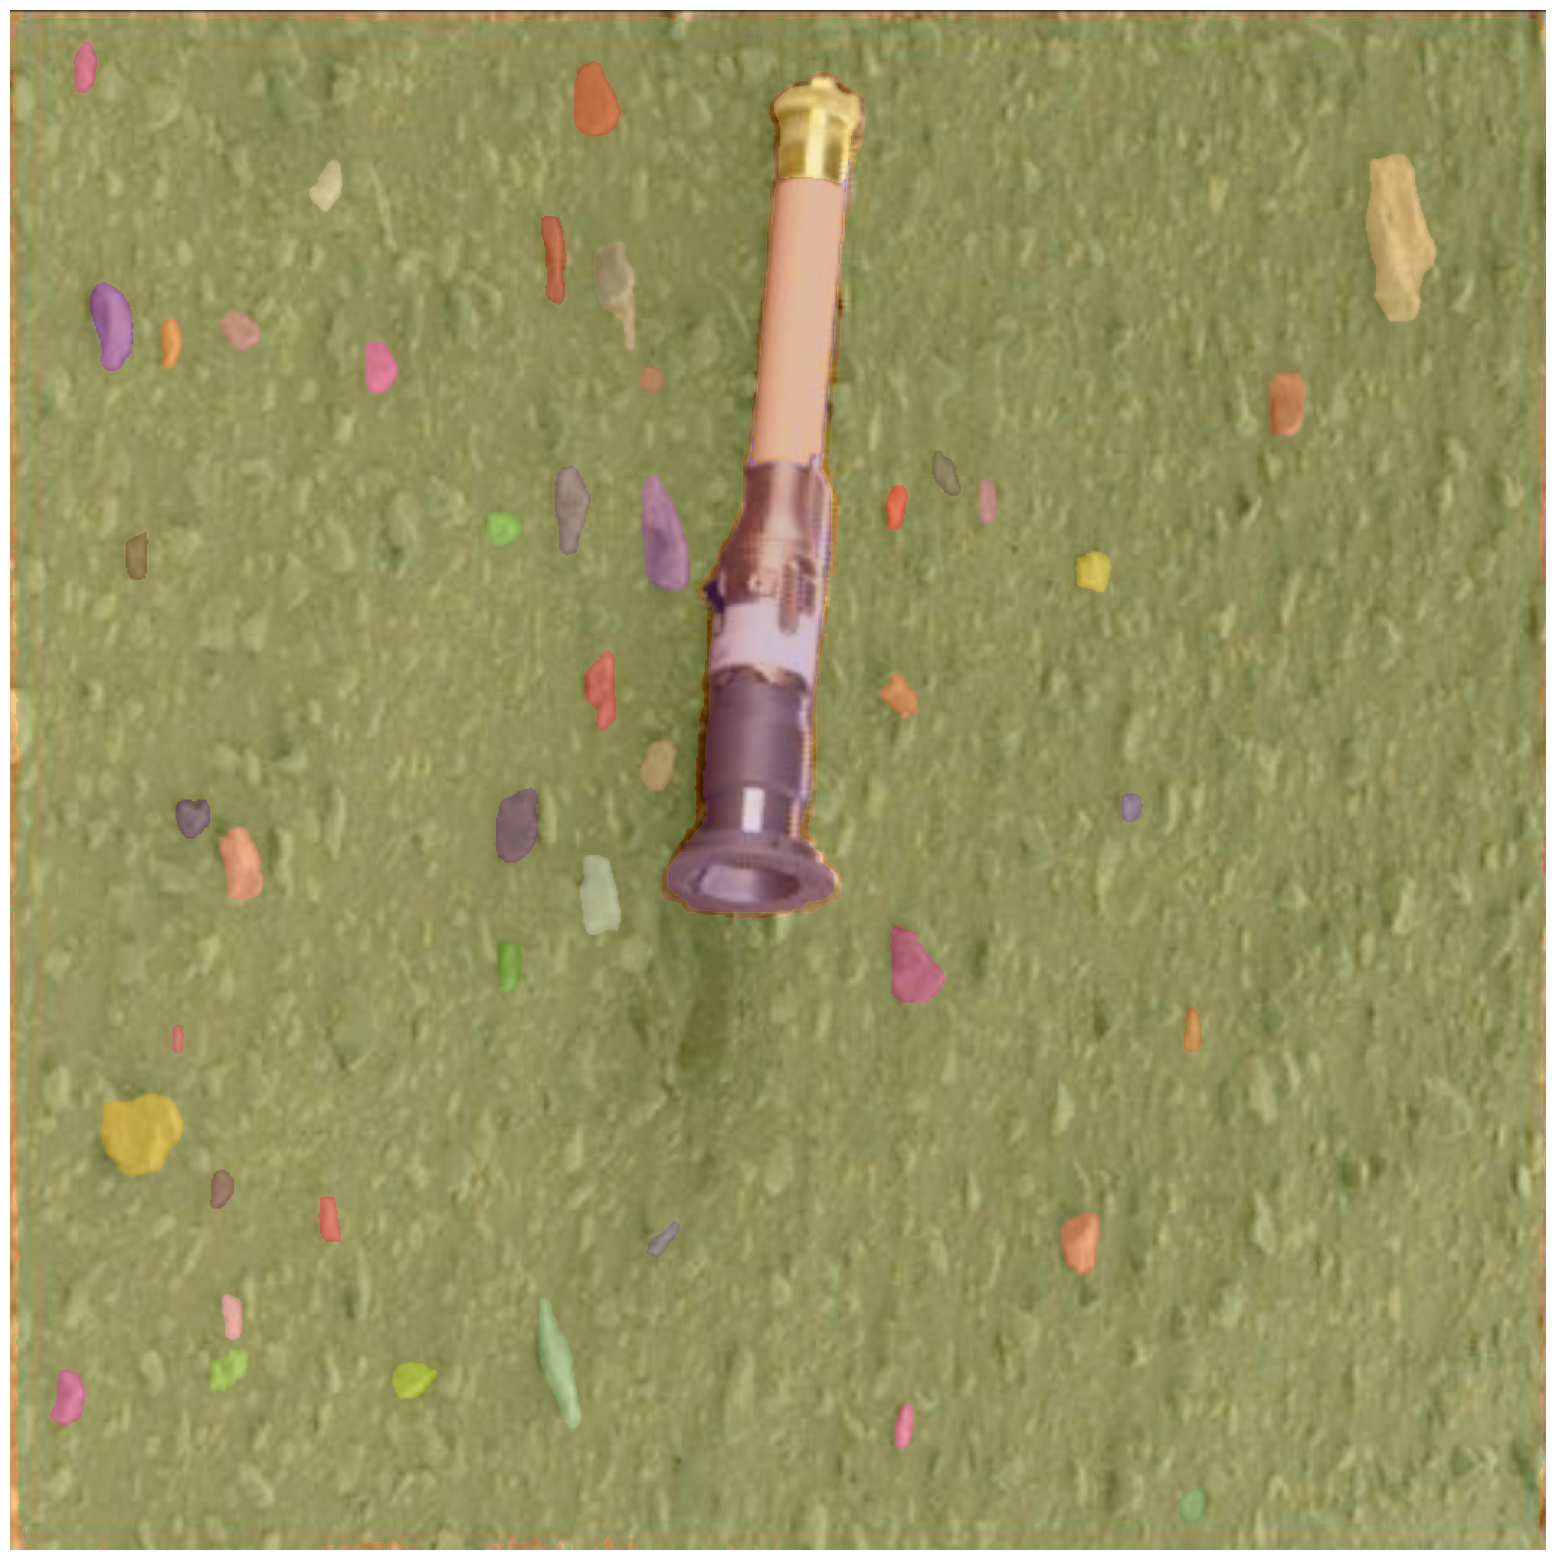

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [21]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.8,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=50,  # Requires open-cv to run post-processing
)

In [22]:
masks2 = mask_generator_2.generate(image)

In [23]:
len(masks2)

105

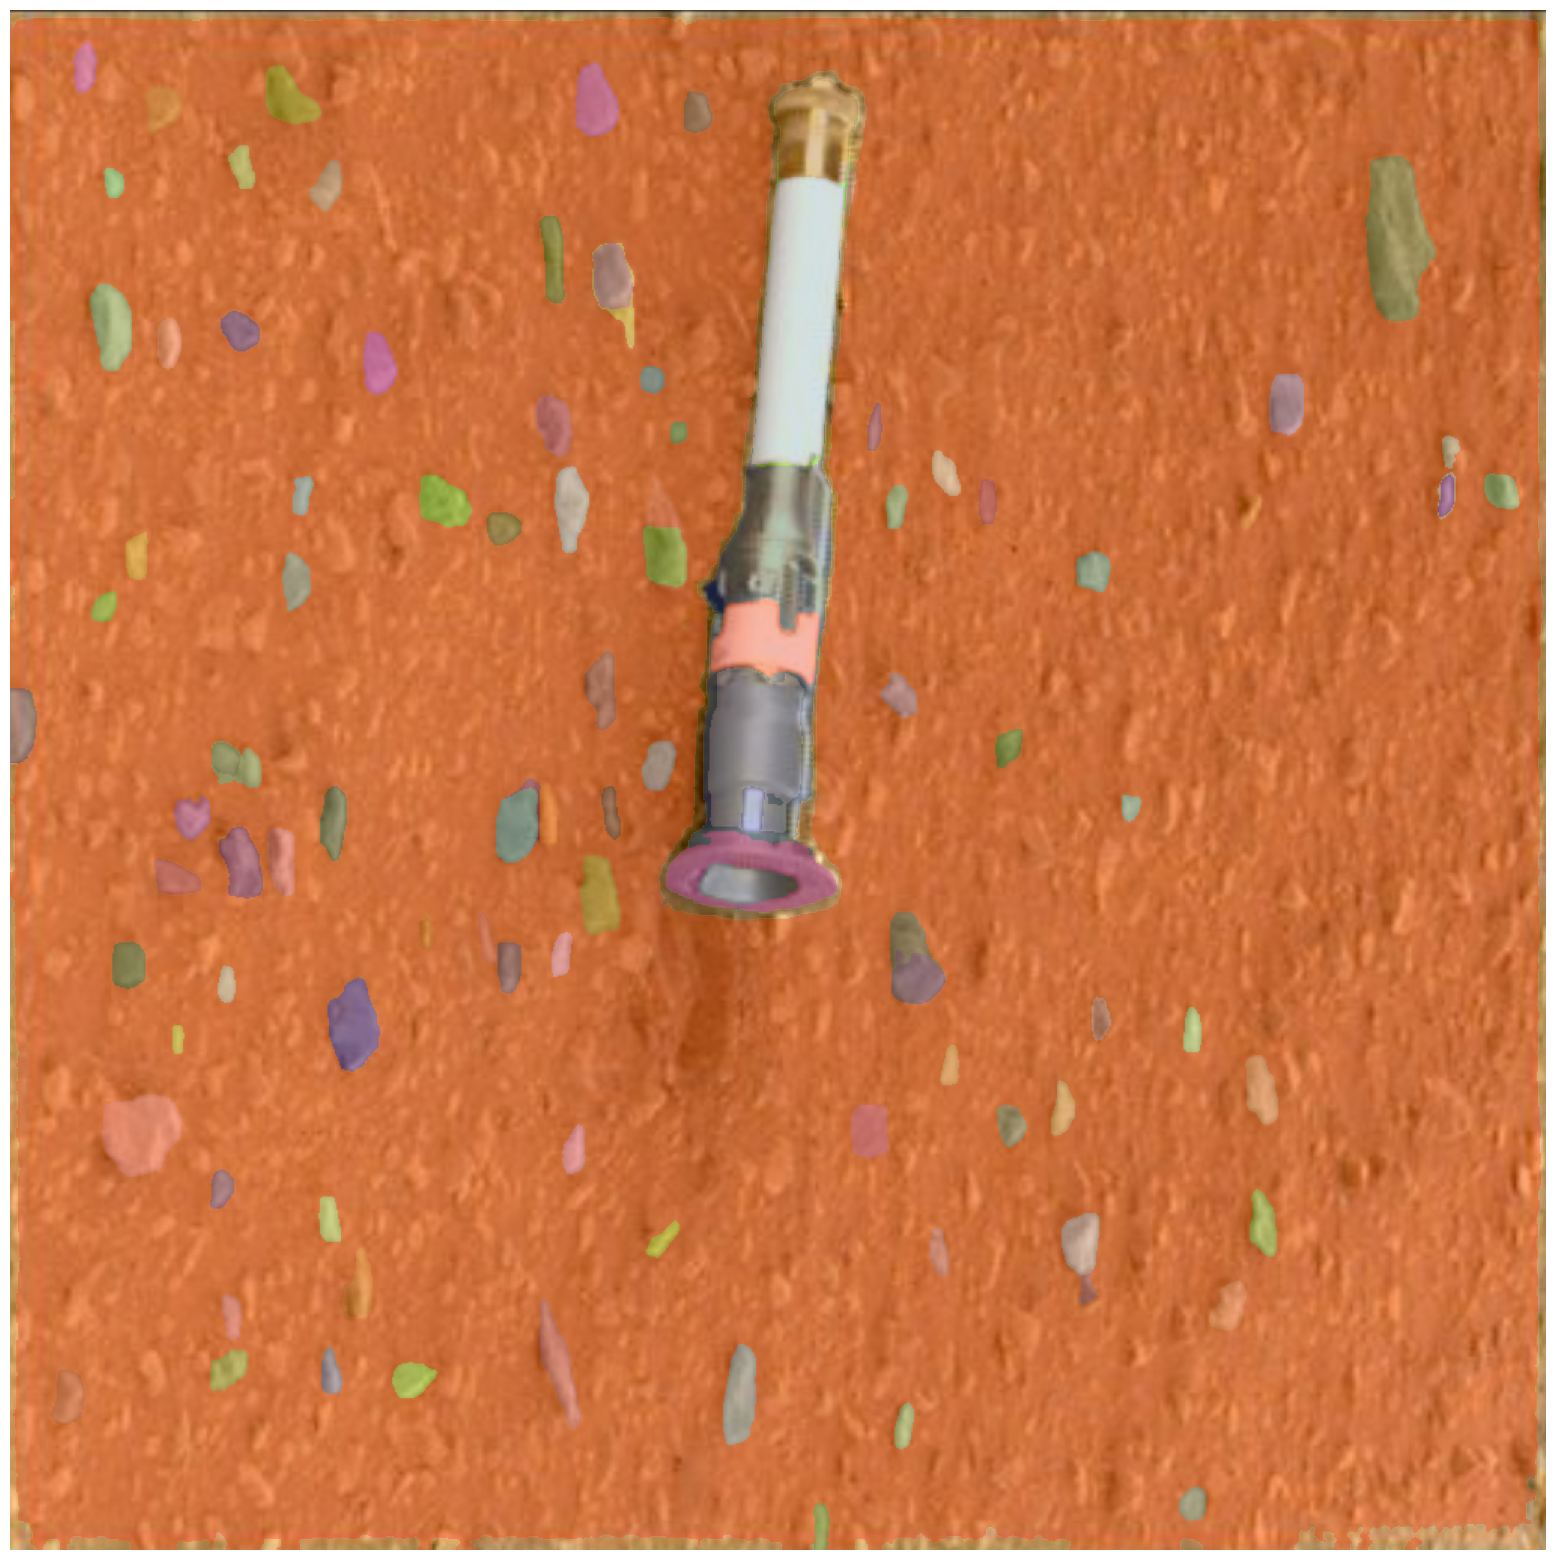

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 